In [1]:
!pip install -U git+https://github.com/d2l-ai/d2l-en.git@master

  Cloning https://github.com/d2l-ai/d2l-en.git (to revision master) to /tmp/pip-req-build-_rqy_hkc
  Running command git clone -q https://github.com/d2l-ai/d2l-en.git /tmp/pip-req-build-_rqy_hkc
  Created wheel for d2l: filename=d2l-0.15.1-cp36-none-any.whl size=63507 sha256=4251db2e1e723315714175f24d5e9e3bf188bf2f40f39c01900fc698ceecfa2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-0_g6fge0/wheels/0f/41/8f/72ece70ede8a0e37eec72c03087eb4604925ba212b804f8cad
Successfully built d2l


In [2]:
from d2l import torch as d2l
import torch
from torch import nn

In [3]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention_cell = d2l.MLPAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_len, *args):
        outputs, hidden_state = enc_outputs
        # Transpose outputs to (batch_size, seq_len, num_hiddens)
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_len)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs = []
        for x in X:
            # query shape: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context has same shape as query
            context = self.attention_cell(
                query, enc_outputs, enc_outputs, enc_valid_len)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x to (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_len]

In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8,
                             num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8,
                                  num_hiddens=16, num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 5512.2 tokens/sec on cuda:0


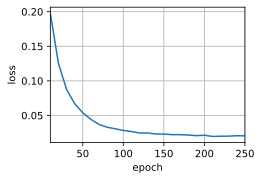

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, tgt_vocab, device)

In [6]:
engs = ['go .', "i lost .", 'i\'m home .', 'he\'s calm .']
fras = ['va !', 'j\'ai perdu .', 'je suis chez moi .', 'il est calme .']
d2l.translate(engs, fras, model, src_vocab, tgt_vocab, num_steps, device)

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
i'm home . => je suis chez moi ., bleu 1.000
he's calm . => il est malade ., bleu 0.658
